## Assignment Week 5

### RAG using Wikipedia

In [1]:
import json
import os

In [2]:
# get api key from file
with open("../../apikeys/openai-keys.json", "r") as key_file:
    api_key = json.load(key_file)["default_api_key"]
os.environ["OPENAI_API_KEY"] = api_key

#### Load Wikipedia page

In the activities below prompt engineering approach such as zero-shot, one-shot and COT are demonstrated in simplest form to generate better quality json data from an invoice using OpenAI LLM (chatgp-4o-mini). 

[2025 California wildfires][1]

[1]https://en.wikipedia.org/wiki/2025_California_wildfires

In [3]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [4]:
search_term = "January 2025 Southern California wildfires"
docs = WikipediaLoader(query=search_term, load_max_docs=2).load()

In [5]:
print(f"Length of docs: {len(docs)}")
print(f"{json.dumps(docs[0].metadata, indent=2)}")

Length of docs: 2
{
  "title": "January 2025 Southern California wildfires",
  "summary": "Since January 7, 2025, an ongoing series of 23 catastrophic wildfires have affected the Los Angeles metropolitan area and surrounding regions. The fires have been exacerbated by drought conditions, low humidity, and hurricane-force Santa Ana winds, which in some places have reached 100 miles per hour (160 km/h; 45 m/s). As of January 14, 2025, the wildfires have killed at least 25 people, forced over 200,000 to evacuate, and destroyed or damaged more than 12,401 structures. Most of the damage has been done by the two largest fires: the Palisades Fire in Pacific Palisades and the Eaton Fire in Altadena. They are likely the second and fourth most destructive fires in California's history, respectively.\n\n",
  "source": "https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires"
}


chunk-size based on performance and context window

In [6]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap  = 50,
    length_function = len,
    is_separator_regex = False,
)

data = text_splitter.split_documents(docs)
data[:3]


[Document(metadata={'title': 'January 2025 Southern California wildfires', 'summary': "Since January 7, 2025, an ongoing series of 23 catastrophic wildfires have affected the Los Angeles metropolitan area and surrounding regions. The fires have been exacerbated by drought conditions, low humidity, and hurricane-force Santa Ana winds, which in some places have reached 100 miles per hour (160 km/h; 45 m/s). As of January 14, 2025, the wildfires have killed at least 25 people, forced over 200,000 to evacuate, and destroyed or damaged more than 12,401 structures. Most of the damage has been done by the two largest fires: the Palisades Fire in Pacific Palisades and the Eaton Fire in Altadena. They are likely the second and fourth most destructive fires in California's history, respectively.\n\n", 'source': 'https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires'}, page_content='Since January 7, 2025, an ongoing series of 23 catastrophic wildfires have affected the Los Ange

In [7]:
import tiktoken as tk

In [8]:
encoding = tk.get_encoding("cl100k_base")
encoded_string = encoding.encode(data[0].page_content)
num_tokens = len(encoded_string)
num_tokens

113

### Storing embeddings in ChromaDB

In [9]:
from langchain.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

[text-embedding-3-small][1]

[1]:https://platform.openai.com/docs/guides/embeddings
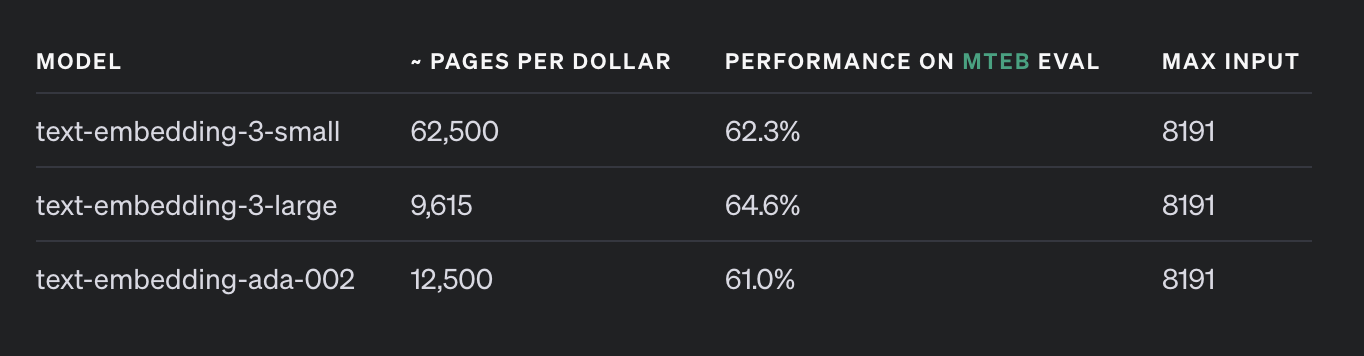

In [10]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [11]:
store = Chroma.from_documents(
    collection_name="wikipedia_california_fire_embeddings",
    documents=data,
    embedding=embeddings,
    ids=[f"{doc.metadata['source']}_{index}" for index, doc in enumerate(data)],
    persist_directory="./vector-stores/chroma/"
)

#### Asking questions about 2024 california fires

In [12]:
from langchain_openai import ChatOpenAI

### Without RAG

Question 1: How many people were killed in southern california wildfire in January 2025?

In [13]:
openai_model = ChatOpenAI(model="gpt-4o-mini")

In [39]:
messages=[
        {
            "role": "system", 
            "content": f"You are a bot that answers questions about January 2025 Southern California wildfires.\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: How many people were killed in southern california wildfire in January 2025?\nA:"
        }
    ]

In [40]:
response = openai_model.invoke(messages)

In [41]:
print(f"Response from LLM without RAG:\n {response.content}")

'I do not know.'

In [29]:
#show response details
response

AIMessage(content='I do not know.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 74, 'total_tokens': 80, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-a7bef2c1-4493-4987-8452-94fd483de0b5-0', usage_metadata={'input_tokens': 74, 'output_tokens': 6, 'total_tokens': 80, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### With RAG

In [32]:
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
import pprint

In [34]:
template = "You are a bot that answers questions about January 2025 Southern California wildfires.\n\
            If you donot know the answer, simply state that you donot know.\n\
            {context}\n\
            Question: {question}"

PROMPT = PromptTemplate(
    template=template, input_variables=["context", "question"]
)

In [35]:
llm = ChatOpenAI(temperature=0, model="gpt-4o-mini")

In [36]:
qa_with_source = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=store.as_retriever(),
    chain_type_kwargs={"prompt": PROMPT, },
    return_source_documents=True,
)

In [38]:
pprint.pprint(
    qa_with_source("How many people were killed in southern california wildfire in January 2025?")
)

{'query': 'how many people were killed in souther calrifornia wildfire in '
          'January 2025?',
 'result': 'As of January 14, 2025, the wildfires in Southern California have '
           'killed at least 25 people.',
 'source_documents': [Document(metadata={'source': 'https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires', 'summary': "Since January 7, 2025, an ongoing series of 23 catastrophic wildfires have affected the Los Angeles metropolitan area and surrounding regions. The fires have been exacerbated by drought conditions, low humidity, and hurricane-force Santa Ana winds, which in some places have reached 100 miles per hour (160 km/h; 45 m/s). As of January 14, 2025, the wildfires have killed at least 25 people, forced over 200,000 to evacuate, and destroyed or damaged more than 12,401 structures. Most of the damage has been done by the two largest fires: the Palisades Fire in Pacific Palisades and the Eaton Fire in Altadena. They are likely the second 

### Without RAG

Question 2: What is largest wildfire among california wildfires in 2025?

In [43]:
messages=[
        {
            "role": "system", 
            "content": f"You are a bot that answers questions about January 2025 Southern California wildfires.\n\
            If you donot know the answer, simply state that you donot know."
        },
        {
            "role": "user", 
            "content": f"Q: What is largest wildfire among california wildfires in 2025?\nA:"
        }
    ]

In [44]:
response = openai_model.invoke(messages)

In [45]:
print(f"Response from LLM without RAG:\n {response.content}")

Response from LLM without RAG:
 I do not know.


### Without RAG

In [46]:
pprint.pprint(
    qa_with_source("What is largest wildfire among california wildfires in 2025?")
)

{'query': 'What is largest wildfire among california wildfires in 2025?',
 'result': 'The largest wildfire among the California wildfires in 2025 is the '
           'Palisades Fire in Pacific Palisades.',
 'source_documents': [Document(metadata={'source': 'https://en.wikipedia.org/wiki/January_2025_Southern_California_wildfires', 'summary': "Since January 7, 2025, an ongoing series of 23 catastrophic wildfires have affected the Los Angeles metropolitan area and surrounding regions. The fires have been exacerbated by drought conditions, low humidity, and hurricane-force Santa Ana winds, which in some places have reached 100 miles per hour (160 km/h; 45 m/s). As of January 14, 2025, the wildfires have killed at least 25 people, forced over 200,000 to evacuate, and destroyed or damaged more than 12,401 structures. Most of the damage has been done by the two largest fires: the Palisades Fire in Pacific Palisades and the Eaton Fire in Altadena. They are likely the second and fourth most de

In [47]:
qa_with_source

RetrievalQA(verbose=False, combine_documents_chain=StuffDocumentsChain(verbose=False, llm_chain=LLMChain(verbose=False, prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template='You are a bot that answers questions about January 2025 Southern California wildfires.\n            If you donot know the answer, simply state that you donot know.\n            {context}\n            Question: {question}'), llm=ChatOpenAI(client=<openai.resources.chat.completions.Completions object at 0x16298bfb0>, async_client=<openai.resources.chat.completions.AsyncCompletions object at 0x16298ce30>, root_client=<openai.OpenAI object at 0x162988b30>, root_async_client=<openai.AsyncOpenAI object at 0x162989f10>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), output_parser=StrOutputParser(), llm_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={

In `one-shot prompting` above, we do not need to provide details of the shoe prices and information about the required attributes in json separately in prompt like `zero-shot prompting`. Instead an `example` of `email body` and corresponding expected `json` output were provided in the prompt. The `examples` enabled the LLM to steer it response to the desired output including all the details. The LLM was able to infer the prices of each kind of shoes from the example itself. The output json has all the attributes exactly as mentioned in the example in this case.

It is worth to note that the cost of the task is higher in the `one shot` promting compared to `zero shot` because we needed to provide an entire email body and an entire json example in the prompt which increased the number of input tokens hence more cost. However, even though cost was higher we were able to get more tailored response. Therefore, cost and output performance must be evaluated before choosing the type of prompting for a task.

### Problem #2: Chat Completion for Chain of Thought

We observe that the issue of `null` in the amount attributes is fixed as soon as the price of each item is passed in the prompt. However, we notice that the attribute containing the list of shoes is named as `shoes` instead of `items` as required in the [sample output][1] of the assignmnt provided in BB. This may be resolved by trying `one-shot prompting` where we provide an example with email body and corresponding json output which will serve as an example for the LLM to better understnad the schema and gnerate correct json matching the requirement.

[1]:https://cyberactive.bellevue.edu/bbcswebdav/xid-104820287_4

`Chain of thought` is a prompting technique that enables reasoning capabilities in LLM responses by providing reasoning examples in the prompt. As observed above, the response yeilded correct result with the use of `chain of thougt` in promt allowing the LLM to understand the mathematical reasoning and generate correct result. It is worth to note that apart from just the answer, LLM response also includes a step by step explanation about how it arrived at the result.

In [49]:
from langchain.embeddings import OpenAIEmbeddings